In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# sku: Identificador de producto relacionado al evento.
# Por esa razon lo consideramos object
df = pd.read_csv('data/events.csv', dtype={'sku':object})

In [3]:
# veamos el shape que tiene el dataset
df.shape

(1011288, 23)

In [4]:
# veamos los tipos de las variables
df.dtypes

timestamp                   object
event                       object
person                      object
url                         object
sku                         object
model                       object
condition                   object
storage                     object
color                       object
skus                        object
search_term                 object
staticpage                  object
campaign_source             object
search_engine               object
channel                     object
new_vs_returning            object
city                        object
region                      object
country                     object
device_type                 object
screen_resolution           object
operating_system_version    object
browser_version             object
dtype: object

Para poder trabajar con el dato del timestamp, es necesario convertirlo en a tipo *datetime*. De esta forma se pueden almacenar los distintos datos contenidos en el timestamp de forma separada.

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
# separemos las cosas para que quede algo manejable; no tiene sentido tener el timestamp todo junto
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour

In [14]:
df['date'] = df['timestamp'].dt.date

## Un breve análisis sobre los datos temporales

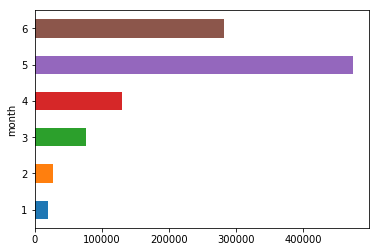

In [15]:
df.groupby('month').count()['person'].plot(kind='barh')

Hay significativamente mas datos del mes 5. Si los datos son representativos, se podria concluir que hubo mucho mas trafico durante el quinto mes (casi el doble que durante el sexto, que ademas tiene aproximadamente el doble que el cuarto, que es el que mas tiene entre los primeros cuatro.  
Surge asi el interrogante: que es lo que hizo que este mes haya tenido mas trafico?

In [47]:
# Se obtiene el día de la semana, se cuenta y se vuelca en un gráfico
days = {6: "Domingo",0: "Lunes",1:"Martes",2: "Miércoles",3: "Jueves",4: "Viernes",5: "Sábado"}

# guardo dias de la semana en el orden deseado
sorter = ["Domingo", "Sábado", "Viernes", "Jueves", "Miércoles", "Martes", "Lunes"]
sorterIndex = dict(zip(sorter,range(len(sorter))))

# se crea columna con info del dia de la semana respetando el nombre
df["dia_semana"] = df["timestamp"].dt.dayofweek
df["dia_semana"] = df["dia_semana"].apply(lambda x: days[x])

Text(0,0.5,'Cantidad de eventos')

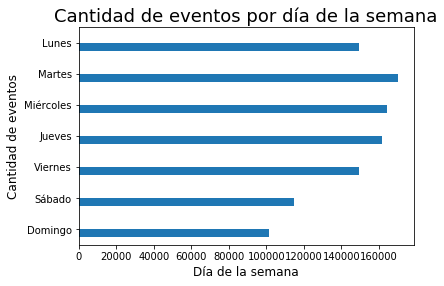

In [70]:
# creo df con cantidad de eventos agrupados por dia de la semana
dfEventosAgrupado = df[['event','dia_semana']].groupby("dia_semana").count()
dfEventosAgrupado["day"] = dfEventosAgrupado.index

# ordenamiento coherente para evitar el default (alfabetico)
dfEventosAgrupado["day"] = dfEventosAgrupado["day"].map(sorterIndex)

grafico = dfEventosAgrupado.sort_values("day").plot(kind = "barh")
grafico.legend_.remove()
grafico.set_title("Cantidad de eventos por día de la semana", fontsize=18)
grafico.set_xlabel("Día de la semana", fontsize=12)
grafico.set_ylabel("Cantidad de eventos", fontsize=12)

Se puede observar que hay menos trafico los fines de semana. Fuera de eso, los niveles se mantienen similares. Se puede suponer que esto se debe a que los fines de semana los usuarios ocupan mas tiempo en actividades sociales y que durante la semana navegan en este tipo de sitios despues del trabajo (o durante? Seguro que no!).

Text(0,0.5,'Cantidad de eventos')

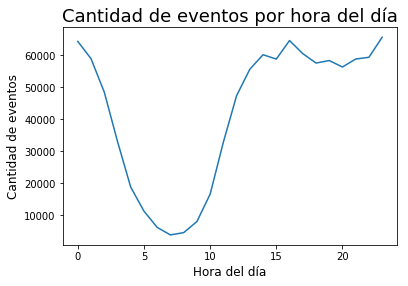

In [50]:
# Se obtiene la hora, se cuenta y se vuelca en un gráfico
grafico = df["timestamp"].dt.hour.value_counts().sort_index().plot()
grafico.set_title("Cantidad de eventos por hora del día", fontsize=18)
grafico.set_xlabel("Hora del día", fontsize = 12)
grafico.set_ylabel("Cantidad de eventos", fontsize = 12)

Como era de esperar, durante la noche se registra una baja en la actividad del sitio.

Text(0.5,1,'cantidad de eventos estudiados por condición')

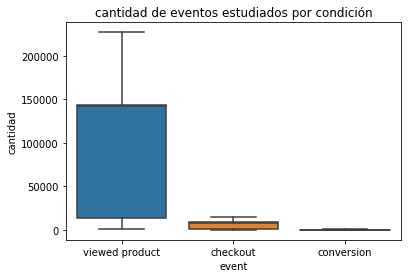

In [51]:
event_condition = df[['condition','event']].\
                    groupby('condition').\
                    apply(lambda x: x['event'].value_counts().reset_index(name='cantidad')).\
                    rename(columns={'index':'event'})

sns.boxplot

sns.boxplot(x="event", y="cantidad", data=event_condition).set_title('cantidad de eventos estudiados por condición')

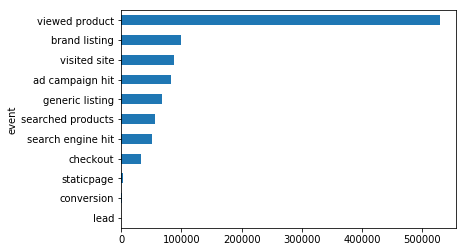

In [75]:
pd.crosstab(index = df["event"],  # Make a crosstab
                     columns="count")\
            .sort_values(['count'])\
            .plot(kind='barh', legend=False)

### Paises

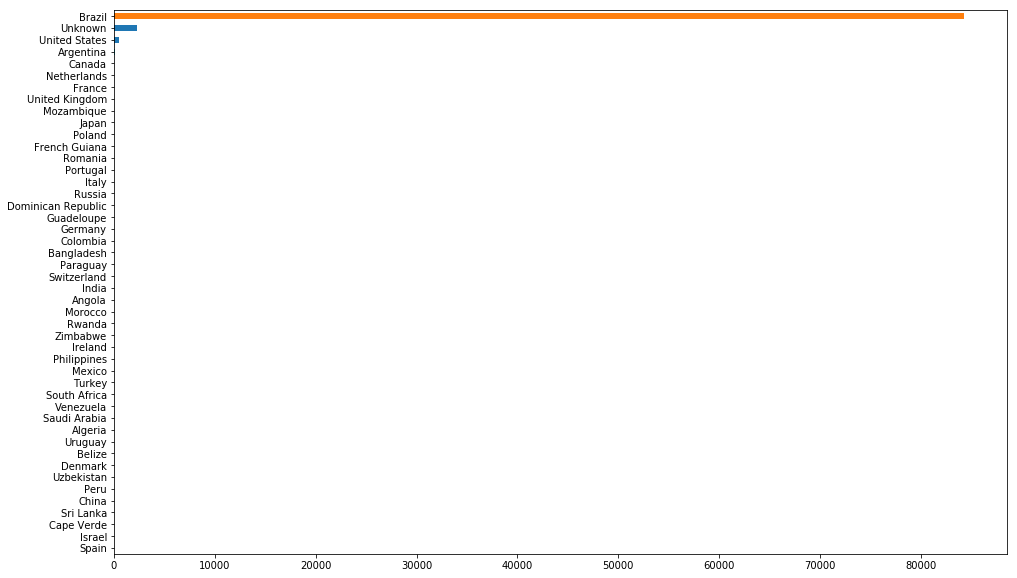

In [23]:
df.country.value_counts(ascending=True).plot(kind='barh', figsize=(16,10))

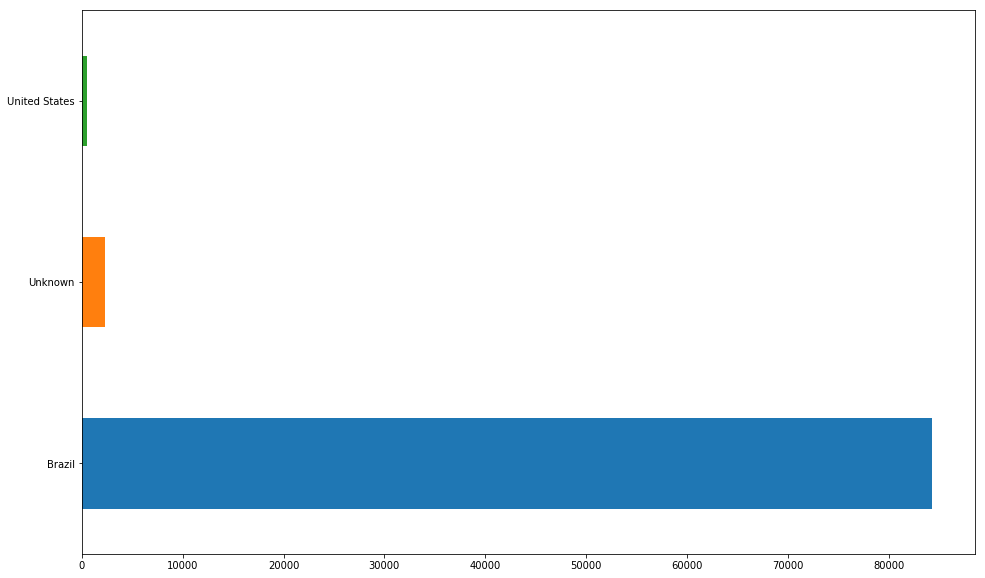

In [7]:
df.country.value_counts().iloc[:3].plot(kind='barh', figsize=(16,10))

Vale la pena siquiera considerar paises que no sean Brasil? Habra que ver qué tendremos que predecir, pero a priori parece insignificante lo que tenemos del resto del mundo.

A continuacion haremos analisis de `city`, ploteando las ciudades en un mapa.

***
## city

In [3]:
len(df.city.dropna().unique())

1939

In [13]:
cities = df.city.dropna().unique()

Habra muchos `NaNs`?

In [15]:
cant_nans = len(df) - df['city'].count()
print("cantidad nans: " + str(cant_nans))
print("porcentaje nans: " + str(cant_nans/len(df)))

cantidad nans: 923910
porcentaje nans: 0.9135973135249306


Hay muchos. Además, el enunciado indica: *city: Ciudad desde donde se originó el evento*, y no hay ningún campo sin información de evento. Una posibilidad es que se registre la ciudad para el primer evento de una sesión, entonces si bien hay muchos más eventos que ciudades, cada una de las ciudades representa una misma sesión y por lo tanto pasa a ser muy significativa la información.

#### Mapas
Consigamos las coordenadas de las ciudades para poder graficarlas en un mapa y ver visualmente dónde están los clientes. Se podria dibujar círculos con radio en funcion de la cantidad de compras del lugar, para tener una idea de la importancia de cada lugar para el estudio de mercado. 

El df que se lee a continuacion tiene las coordenadas de las ciudades que aparecen en el set de datos. Leer directamente el nuevo dataset con la info guardada y seguir a partir de ahi. Para ver el procesamiento detalladamente, ver notebook correspondiente.

In [14]:
cities_with_coordinates = pd.read_csv('data/cities_w_coords_with_completed_nans.csv', index_col=False)

In [15]:
# Lets join the dfs
df.merge(cities_with_coordinates, on=('city'), how='left')

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,browser_version,year,month,day,weekday,hour,year_month_day,Unnamed: 0,city_lat,city_long
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2018,5,31,Thursday,23,2018-05-31,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Chrome Mobile 39,2018,5,31,Thursday,23,2018-05-31,0.0,-8.021383,-34.981077
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,2018,5,31,Thursday,23,2018-05-31,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,2018,5,31,Thursday,23,2018-05-31,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,2018,5,29,Tuesday,13,2018-05-29,NaN,NaN,NaN
5,2018-05-29 13:29:26,visited site,0006a21a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Android 5.1,2018,5,29,Tuesday,13,2018-05-29,1.0,-22.911014,-43.209373
6,2018-05-29 13:29:27,ad campaign hit,0006a21a,/comprar/samsung/galaxy-s8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2018,5,29,Tuesday,13,2018-05-29,NaN,NaN,NaN
7,2018-05-29 13:29:35,checkout,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,2018,5,29,Tuesday,13,2018-05-29,NaN,NaN,NaN
8,2018-04-09 20:12:31,generic listing,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,"10310,13333,13347,9902,9944,12774,12801,12744,...",...,NaN,2018,4,9,Monday,20,2018-04-09,NaN,NaN,NaN
9,2018-04-09 20:12:31,visited site,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Chrome 65.0,2018,4,9,Monday,20,2018-04-09,1.0,-22.911014,-43.209373


### Plotting cities on a map

In [58]:
import folium

In [61]:
from folium.plugins import MarkerCluster

avg_lat = cities_with_coordinates['city_lat'].mean()
avg_long = cities_with_coordinates['city_long'].mean()

m = folium.Map(location=[0, 0], zoom_start=2)

marker_cluster = MarkerCluster().add_to(m)

for lat, lon, city in zip(cities_with_coordinates.city_lat, cities_with_coordinates.city_long, cities_with_coordinates.city):
    folium.Marker(location=[lat, lon]).add_to(marker_cluster)

m

***
Tendran todos los Countries `Unknown` tambien city `Unknown`? Si.

In [63]:
df.loc[df['country'] == 'Unknown']['city'].unique()

array(['Unknown'], dtype=object)

Basicamente, si bien hay "muchos" paises, el grueso es de Brasil. Y de los `Unknown` no se sabe nada.

***
## model

In [70]:
len(df.model.unique())

203

In [71]:
df['model'].head()

0                  NaN
1                  NaN
2            iPhone 5s
3            iPhone 5s
4    Samsung Galaxy S8
Name: model, dtype: object

Habra muchos `NaNs`?

In [72]:
cant_nans = len(df) - df['model'].count()
print("cantidad nans: " + str(cant_nans))
print("porcentaje nans: " + str(cant_nans/len(df)))

cantidad nans: 447004
porcentaje nans: 0.4420145398739034


Veamos cuales son las marcas mas usadas.

In [76]:
for a in df.model.unique():
    print(a)

nan
iPhone 5s
Samsung Galaxy S8
Motorola Moto Z Play
iPhone 7 Plus
iPhone 6S
iPhone 4G
iPhone 4S
Samsung Galaxy J5
iPhone 5c
iPhone 7
iPhone 6
Samsung Galaxy S6 Flat
Motorola Moto G3 4G
Motorola Moto G4 Play DTV
Asus Zenfone 2
iPhone 5
Motorola Moto X Play 4G Dual
Motorola Moto X2
Samsung Galaxy A7 2016
iPhone 6S Plus
Samsung Galaxy Core Plus Duos TV
Samsung Galaxy Win Duos
Samsung Galaxy S7
Samsung Galaxy Core 2 Duos
Samsung Galaxy J7
Quantum GO 4G
Lenovo Vibe A7010 Dual Chip
Sony Xperia M4 Aqua
Motorola Moto G4 Plus
Samsung Galaxy J7 2016 Metal
Samsung Galaxy J1 2016
Lenovo Vibe K5
Motorola Moto G2 3G Dual
Samsung Galaxy Y Duos
Motorola Moto G2 4G Dual
Sony Xperia M4 Aqua Dual
Samsung Galaxy S5
Motorola Moto Z2 Play
Motorola Moto MAXX 
Motorola Moto X Force
Samsung Galaxy S7 Edge
Sony Xperia Z3 Plus
Sony Xperia Z3 Dual
LG G4 H815P
LG G4 H818P
Samsung Galaxy S6 Edge
iPhone 6 Plus
Samsung Galaxy Note 8
Samsung Galaxy J7 Prime
Samsung Galaxy Note 3 Neo Duos
Samsung Galaxy A5
iPad Air 2 

La primera palabra nos indica en cada caso la marca. (Salvo con Apple, que puede ser iPhone o iPad, pero esta distincion incluso puede ser interesante).

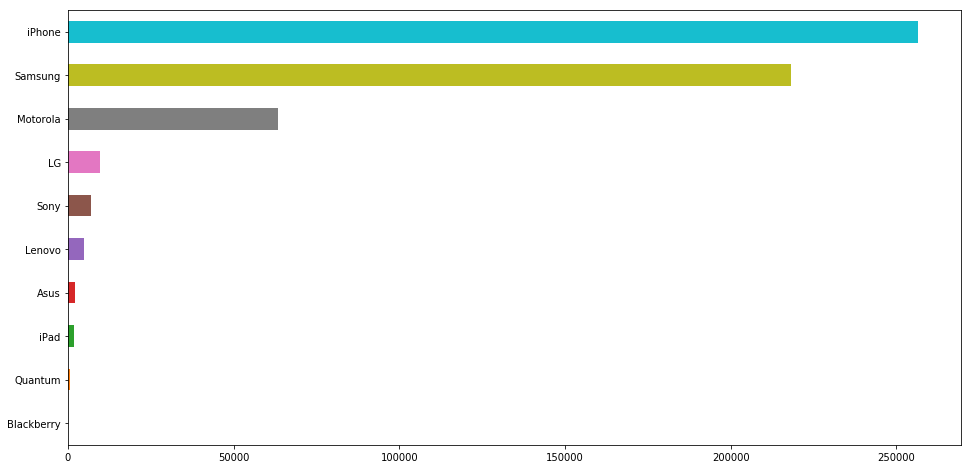

In [115]:
df.model.apply(lambda x: str(x).split()[0]).value_counts(ascending=True)[:-1].plot(kind='barh', figsize=(16,8))

***
## condition

In [107]:
len(df.condition.unique())

6

In [108]:
for ev in df.condition.unique():
    print(ev)

nan
Bom
Muito Bom
Excelente
Bom - Sem Touch ID
Novo


Habra muchos `NaNs`?

In [109]:
cant_nans = len(df) - df['condition'].count()
print("cantidad nans: " + str(cant_nans))
print("porcentaje nans: " + str(cant_nans/len(df)))

cantidad nans: 447452
porcentaje nans: 0.442457539296422


`TODO` pensar en esto. Hay un 45% de nans en esta columna. No es tan tragico como antes, pero no es despreciable tampoco.  
Probablemente se trate de los casos en que no corresponde la indicacion de *condition*.

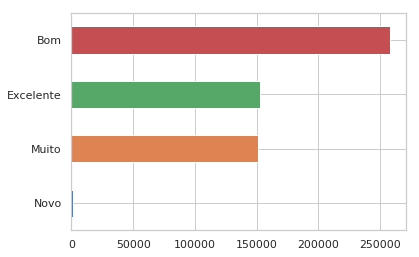

In [140]:
df.condition.apply(lambda x: str(x).split()[0]).value_counts(ascending=True)[:-1].plot(kind='barh')

***
## storage

In [116]:
len(df.storage.unique())

9

In [117]:
for ev in df.storage.unique():
    print(ev)

nan
32GB
64GB
256GB
16GB
8GB
128GB
4GB
512MB


Habra muchos `NaNs`?

In [118]:
cant_nans = len(df) - df['storage'].count()
print("cantidad nans: " + str(cant_nans))
print("porcentaje nans: " + str(cant_nans/len(df)))

cantidad nans: 447452
porcentaje nans: 0.442457539296422


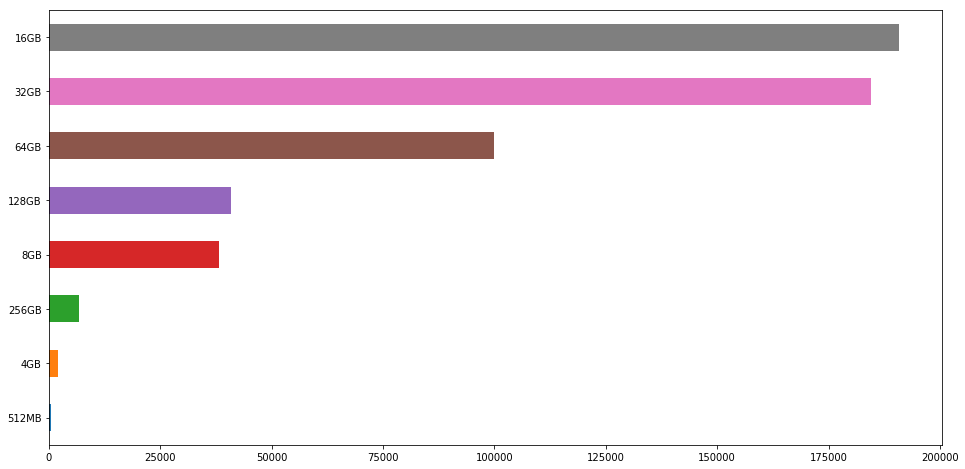

In [120]:
df.storage.apply(lambda x: str(x).split()[0]).value_counts(ascending=True)[:-1].plot(kind='barh', figsize=(16,8))

***
## campaign source

In [17]:
len(df.campaign_source.unique())

25

In [18]:
for ev in df.campaign_source.unique():
    print(ev)

criteo
nan
google
FacebookAds
zanox
rtbhouse
voxus
bing
afilio
emblue
mercadopago
FacebookSocial
datacrush
indexa
buscape
Facebook
rakuten
blog
yotpo
manifest
afiliado
MARKETING SOCIAL
socialmedia
Google Social
onsite


Habra muchos `NaNs`?

In [19]:
cant_nans = len(df) - df['campaign_source'].count()
print("cantidad nans: " + str(cant_nans))
print("porcentaje nans: " + str(cant_nans/len(df)))

cantidad nans: 928492
porcentaje nans: 0.9181281692257794


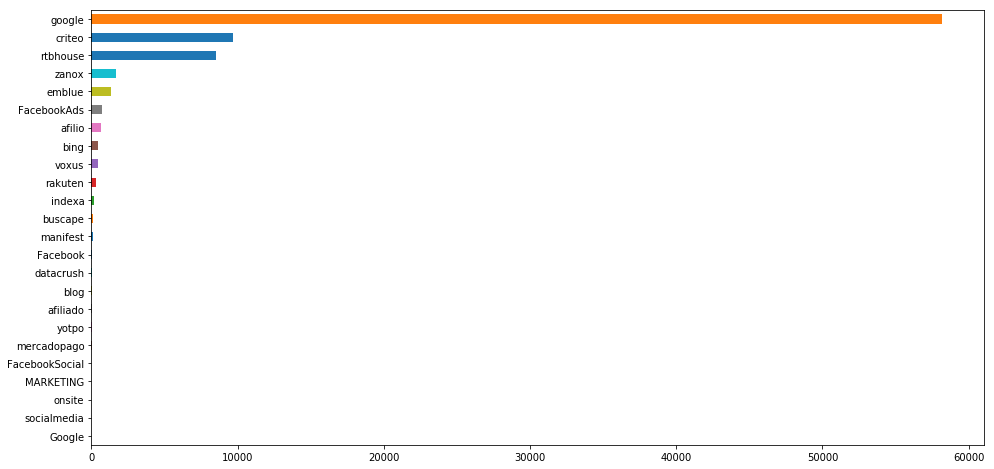

In [28]:
df.campaign_source.dropna().apply(lambda x: str(x).split()[0]).value_counts(ascending=True).plot(kind='barh', figsize=(16,8))